In [8]:
from typing import Annotated, Optional, Union
from datetime import date, datetime

import os

from typing_extensions import TypedDict

import pytz

import psycopg2
from psycopg2.extras import RealDictCursor

from langchain_core.runnables import ensure_config
from langchain_core.tools import tool

from langgraph.graph.message import AnyMessage, add_messages

from dotenv import load_dotenv
load_dotenv()


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: dict[str, str] 

In [2]:
os.environ['PYTHONPATH']

':/Users/panna/code/artemis:/Users/panna/code/artemis/plugins'

In [20]:
from src.sandbox.db_utils import fetch_user, fetch_user_profile, update_user_profile

@tool
def fetch_user_info():
    """
    Fetch all known immutable information about the user: id, name, email, height, date of birth

    Returns:
        The user's information, as described above.
    """
    config = ensure_config()
    configuration = config.get("configurable", {})
    user_id = configuration.get("user_id")
    if not user_id:
        raise ValueError("User ID is not set in the configuration")
    
    user_profile = fetch_user(user_id)
    return user_profile

@tool
def fetch_user_profile_info():
    """
    Fetch all known mutable information about the user: weight, fitness level, activity preferences, workout constraints, goal weight, workout frequency, workout location, workout duration.

    Returns:
        The user's profile information, as described above.
    """
    config = ensure_config()
    configuration = config.get("configurable", {})
    user_id = configuration.get("user_id")
    if not user_id:
        raise ValueError("User ID is not set in the configuration")
    
    user_profile = fetch_user_profile(user_id)
    return user_profile

@tool
def set_user_profile_info(user_profile_field: str, user_profile_value: Union[str, int, float]):
    """
    Given the provided field and value, update the user's profile information. 
    If the field is already set to the provided value, don't use this tool.

    The schema for the user_profiles table is as follows:
     weight REAL,
     fitness_level TEXT,
     activity_preferences TEXT,
     workout_constraints TEXT,
     goal_weight REAL,
     workout_frequency INTEGER,
     workout_location TEXT,
     workout_duration INTEGER,
    """

    config = ensure_config()
    configuration = config.get("configurable", {})
    user_id = configuration.get("user_id")
    if not user_id:
        raise ValueError("User ID is not set in the configuration")
    
    update_user_profile(user_id, user_profile_field, user_profile_value)

    return f"Successfully updated {user_profile_field} to {user_profile_value} for user {user_id}"
    

In [21]:
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import ToolMessage

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

In [22]:
from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            user_id = config.get("user_id", None)
            state = {**state, "user_id": user_id}
            result = self.runnable.invoke(state)
            # If the LLM happens to return an empty response, we will re-prompt it
            # for an actual response.
            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


# Haiku is faster and cheaper, but less accurate
# llm = ChatAnthropic(model="claude-3-haiku-20240307")
llm = ChatAnthropic(model="claude-3-sonnet-20240229", temperature=1)
# You could swap LLMs, though you will likely want to update the prompts when
# doing so!
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model="gpt-4-turbo-preview")

primary_assistant_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful personal trainer. "
            " When replying, you should sound friendly, knowledgeable, and encouraging. "
            " Do not mention any tools that you used to lookup information. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user:\n<User>\n{user_info}\n</User>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now())

part_1_tools = [
    fetch_user_profile_info,
    set_user_profile_info,
]
part_1_assistant_runnable = primary_assistant_prompt | llm.bind_tools(part_1_tools)

In [6]:
part_1_tools

[StructuredTool(name='fetch_user_profile_info', description="Fetch all known mutable information about the user: weight, fitness level, activity preferences, workout constraints, goal weight, workout frequency, workout location, workout duration.\n\nReturns:\n    The user's profile information, as described above.", args_schema=<class 'pydantic.v1.main.fetch_user_profile_infoSchema'>, func=<function fetch_user_profile_info at 0x10dd80ea0>),
 StructuredTool(name='set_user_weight', description="Given the provided user_weight, update the user's weight in the database.", args_schema=<class 'pydantic.v1.main.set_user_weightSchema'>, func=<function set_user_weight at 0x10dd81620>)]

In [23]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
import json

builder = StateGraph(State)

def serialize_realdictrow(row):
    def convert_value(value):
        if isinstance(value, date):
            return value.isoformat()  # Convert date to ISO format string
        return value

    return {key: convert_value(value) for key, value in row.items()}

def user_info(state: State):
    user_info = serialize_realdictrow(fetch_user_info.invoke({}))
    user_info = json.dumps(user_info, indent=4)

    return {"user_info": user_info}


# Define nodes: these do the work
builder.add_node("fetch_user_info", user_info)
builder.set_entry_point("fetch_user_info")
builder.add_node("assistant", Assistant(part_1_assistant_runnable))
builder.add_node("tools", create_tool_node_with_fallback(part_1_tools))
builder.add_edge("fetch_user_info", "assistant")
# Define edges: these determine how the control flow moves
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = SqliteSaver.from_conn_string(":memory:")
part_1_graph = builder.compile(checkpointer=memory)

In [24]:
import uuid

questions = ["What's my goal weight?",
             "Can you update my goal weight to 80?",
             ]


thread_id = str(uuid.uuid4())

config = {"configurable": {"user_id": "bf9d8cd5-3c89-40ef-965b-ad2ff148e52a", "thread_id": thread_id}}

_printed = set()
for question in questions:
    events = part_1_graph.stream({"messages": ("user", question)}, config, stream_mode="values")
    for event in events:
        _print_event(event, _printed)

================================ Human Message =================================

What's my goal weight?
================================== Ai Message ==================================

[{'text': 'Let me quickly check your profile information to see if your goal weight is listed.', 'type': 'text'}, {'id': 'toolu_01Y8h1csB9sL6JMLM25F1BxY', 'input': {}, 'name': 'fetch_user_profile_info', 'type': 'tool_use'}]
Tool Calls:
  fetch_user_profile_info (toolu_01Y8h1csB9sL6JMLM25F1BxY)
 Call ID: toolu_01Y8h1csB9sL6JMLM25F1BxY
  Args:
================================= Tool Message =================================
Name: fetch_user_profile_info

RealDictRow({'user_profile_id': '3048ae8f-2edc-4905-990e-083d242e5a05', 'user_id': 'bf9d8cd5-3c89-40ef-965b-ad2ff148e52a', 'weight': 72.2, 'fitness_level': 'intermediate', 'activity_preferences': 'running, weightlifting', 'workout_constraints': 'limited time', 'goal_weight': 80.0, 'workout_frequency': 4, 'workout_location': 'gym', 'workout_duration': 60, 

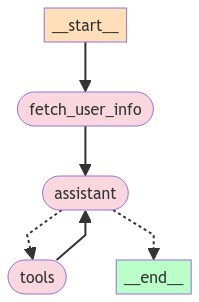

In [41]:
from IPython.display import Image, display

try:
    display(Image(part_1_graph.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass